# Ch4.The Unreasonable Effectiveness of Linear Regression

이번 장에서는 중요한 편향 제거 기법인 선형회귀(Linear Regression)과 최소제곱법(Ordinary Least Sqaure,OLS), 직교화(Orthogonalization)를 다룬다. 처치와 결과 사이의 관계를 추정할 때 선형회귀분석을 사용하면 교란 요인의 영향을 보정하는데 도움이 되는지 알아본다. 더 나아가 처치 직교화라는 강력한 개념도 배운다. 해당 개념은 선형회귀에서 비롯되었으며, 나중에 인과추론에 머신러닝 모델을 적용할 때 유용하게 사용된다.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import graphviz as gr
import matplotlib

from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

style.use("ggplot")
import statsmodels.formula.api as smf
from cycler import cycler

---

## 4.1 인과추론에서 선형회귀의 필요성

회귀분석은 데이터 과학을 배우는 사람들이 배우는 기본적인 모델 중 하나이며, 비교적 단순하다. 회귀분석은 100년이 넘은 역사를 가진 모델임에도 인과추론에서 여전히 강력하며, 때로는 위험한 도구로 평가받는다. 회귀분석은 인과추론의 핵심이자 가장 많이 사용되는 방법이다. 또한 회귀분석은 추후 배울 대부분의 패널데이터 방법(이중 차분법,DID), 이원고정효과(Two-Way Fixed Effects,TWFE), 머신러닝 방법(이중/편향 제거 머신러닝) 그리고 다른 식별 기법(도구변수,불연속 설계)등 응용 방법론의 주요 구성 요소이기도 하다.

### 모델이 필요한 이유

은행이나 대부 업계에서 대출 금액이나 신용한도가 채무불이행률에 미치는 영향을 알아보려고 한다. 당연히 신용한도를 늘리면 신용카드 대금을 미납할 확률이 높아질 것이다. 하지만 실제 은행 데이터를 살펴보면 신용 한도와 채무불이행률 사이에는 음의 상관관계가 존재한다. 물론 신용 한도를 높일수록 고객의 채무불이행률이 줄어든다는 뜻은 아니다. 오히려, 이는 은행과 대출 회사들이 자체 심사 모델에 따라 채무불이행 가능성이 낮다고 판단되는 고객에게 더 높은 신용 한도를 설정하는 방식, 즉 **처치 배정 메커니즘**을 반영한다는 뜻이다.

지금 나타난 음의 상관관계는 교란편향의 영향 때문이다.

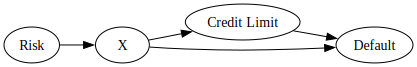

In [3]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

물론 은행은 고객의 채무불이행에 대한 고유 위험을 알 수 없지만, 소득이나 신용점수 같은 대리변수 $X$를 사용하여 이를 추정할 수 있다. 3장에서 처치가 무작위 배정된 것처럼 보이도록 변수를 보정하는 방법을 배웠다.  
$$
ATE = E_x\{E[Y|T=1,X=x]-E[Y|T=0,X=x]\}
$$

여기에 조건부 독립성 가정 $(Y_0,Y_1) \perp T\ |X$이 만족되면 인과효과를 식별할 수 있다.

그러나 해당 보정 공식을 그대로 적용하면 데이터를 특성 $X$에 따라 여러 그룹으로 나눠야 하고, 이는 이산형 변수가 적을 때는 문제가 되지 않지만, 변수가 많고 그 중 일부가 연속형이라면 **차원의 저주(Curse of Dimensionality)** 가 발생한다. 예를 들어, 은행이 고객을 평가하고 신용 한도를 배정할 때 10개의 변수를 사용하고, 각 변수에 3개의 그룹이 있다고 가정해본다. 이것만으로도 $3^{10}=59049$개의 셀이 생성된다. 각 셀에서 $ATE$를 추정하고 각 결과의 평균값을 구하려면 엄청난 양의 데이터가 있을 때만 가능하다. 차원의 저주 때문에 공변량이 많을 때 보정 공식을 그대로 적용하면 **희소성(Sparsity) 문제**가 발생할 수 있다.

차원의 저주를 해결하는 방법은 **잠재적 결과를 선형회귀 같은 방식으로 모델링**할 수 있다고 가정하고, $X$로 정의된 각각의 셀을 **내삽(Interpolate)** 하고 **외삽(Extrapolate)** 하는 것이다. 이 알고리즘은 결과변수를 $X$ 변수로 투영한 후, 이 투영된 값들을 바탕으로 실험군과 대조군을 비교한다. 회귀분석을 충분히 이해하기 위해 먼저 A/B 테스트와 회귀분석의 관계를 알아본다.

### A/B 테스트와 회귀분석의 관계

온라인 스트리밍 회사에서 추천 시스템을 개선한다고 가정해보자. 관리자 입장에서는 새로운 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는지 궁금할 것이다. 이를 시험해보려고 A/B 테스트를 진행한다. 먼저 고객층을 대표할 일부 고객 표본을 추출하고, 그 다음 표본에서 무작위로 1/3을 골라 새 추천 시스템을 적용하고 나머지는 이전 버전의 추천 시스템을 계속 사용하게 한다. 한 달 후, 하루 평균 시청 시간 결과를 수집한다.

In [4]:
import pandas as pd
import numpy as np

url='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/rec_ab_test.csv'

data=pd.read_csv(url)

data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


추천 시스템의 버전이 **무작위**로 배정되었으므로 버전 간의 평균 시청 시간을 단순한 비교만으로도 $ATE$를 알 수 있다. 그러나 통계적 유의성을 확인하려고 표준오차를 계산하여 신뢰구간을 구하는 번거로운 과정을 거쳐야 한다. 그런데 A/B 테스트 결과를 회귀분석으로 해석하면, 필요한 모든 추론 통계량(inference statistic)을 바로 얻을 수 있다. 회귀분석의 기본 아이디어는 다음과 같은 모델을 추정하는 것이다.
$$
WatchTime_i=\beta_0 + \beta_1 challenger_i+e_i
$$

여기서 $challenger$는 새로운 추천 시스템이 적용되면 1, 아니면 0이다. 이 모델을 추정하는 경우, 새로운 버전의 효과는 $\beta_1$의 추정값인 $\hat{\beta_1}$이 된다.

파이썬에서 회귀 모델을 실행하려면 `statsmodels` 패키지 API를 사용하면 된다. 이를 사용하면 R 스타일 수식을 사용하여 선형모델을 간결하게 표현할 수 있다. 예를 들어 앞의 모델을 `'watch_time~C(recommender)`로 표현할 수 있다. 모델을 추정하려면 `.fit()` 메서드를, 결과를 불러오려면 `.summary()` 메서드를 사용하면 된다.

In [5]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)',data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


`recommender` 변수는 범주가 두 개(새로운 버전의 추천 시스템과 기존 버전)인 범주형 변수이다. 열이 범주형임을 나타내려면 해당 변수를 `c(...)`으로 묶어주면 된다.

다음으로 결과를 살펴본다. 먼저, 절편(intercept)은 바로 모델의 $\beta_0$에 대한 추정값이다. 모델의 다른 변수가 0일 때 결과의 기댓값을 알려준다. 여기서 유일하게 다른 변수는 추천 시스템이 새로운 버전인지에 대한 지표이므로, 이 절편은 이전 버전의 추천 시스템을 사용한 고객들의 예상 시청 시간으로 해석할 수 있다. 즉, 기존 버전의 추천 시스템을 사용했을 때 고객이 하루 평균 2.04시간 동안 스트리밍 콘텐츠를 시청한다는 의미이다.

다음으로 $\beta_1$의 추정값을 살펴본다. 이는 새로운 추천 시스템과 관련된 매개변수이다. 이를 보면 새로운 버전 사용에 따른 시청 시간 증가를 볼 수 있다. $\hat{\beta_0}$가 기존 추천 시스템에서의 시청 시간 추정값이라면, $\hat{\beta_0}+\hat{\beta_1}$은 새로운 버전을 이용한 고객 시청 시간의 추정값이다. 즉, **$\hat{\beta_1}$은 $ATE$에 대한 추정값이다.** 무작위 배정 덕분에, 이 추정값에 인과적 의미를 부여할 수 있다. 결과적으로, 새로운 추천 시스템이 평균적으로 하루 시청 시간을 0.14시간 정도 늘렸다. 하지만 이 결과는 통계적으로 유의하지 않다.

결과가 유의하지는 않지만, 이를 통해 $ATE$를 추정했을 뿐만 아니라 동시에 신뢰구간과 p값도 얻었다. 더불어 회귀분석의 원래 목적인 각 처치에 대한 $E[Y|T]$를 추정할 수 있다.

In [6]:
data.groupby('recommender')['watch_time'].mean(())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

앞서 보았듯이, 절편은 수학적으로 대조군(기존 버전의 추천 시스템)에 속한 사용자의 평균 시청시간과 동일하다.  
이는 여기서 회귀분석이 평균을 비교하는 것과 수학적으로 동일하기 때문이다. 결과적으로 $\hat{\beta_1}$이 두 그루 간의 평균 차이인 2.191 - 2.049 = 0.1427을 의미한다. 그래서 실제로 회귀분석으로 그룹 평균을 재현할 수 있다.

### 회귀분석을 통한 보정

신용 한도가 채무불이행률에 미치는 영향을 추정하는 상황으로 돌아가서 회귀분석의 영향을 이해해본다. 은행 데이터는 보통 신용 가치를 나타낼 수 있는 고객 특성들(월급,신용 점수,...)과 해당 고객에게 주어진 신용한도(처치변수), 고객의 채무불이행 여부(결과변수)를 포함한다.

In [7]:
url ='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/risk_data.csv'

risk_data = pd.read_csv(url)
risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


여기서 처치인 `credit_limit`은 너무 많은 범주를 포함한다. 이러한 상황에서 범주형이 아닌 연속형을 처리하는 것이 좋다.

In [8]:
print(risk_data.shape)
risk_data[['credit_limit']].nunique()

(50000, 8)


credit_limit    83
dtype: int64

$ATE$를 여러 처치 수준 간의 차이로 표현하는 대신, 기대 결과의 처치에 대한 **도함수(derivative)** 로 표현할 수 있다.
$$
ATE = \frac{\partial }{\partial t}E[y|t]
$$

이는 단순히 처치가 한 단계 증가할 때 결과가 얼마나 변할지에 대한 기댓값이다. 이 사례에서는 신용한도가 1 달러 증가했을 때 채무불이행률이 얼마나 변할지에 대한 기댓값을 나타낸다.

이런 추정량을 추정하는 한 가지 방법은 회귀분석을 이용하는 것이다. 구체적으로 다음과 같은 모델을 추정하면 된다.
$$
Default_i = \beta_0+\beta_1CreditLim_i+e_i
$$
그리고 추정된 $\hat{\beta_1}$은 신용한도가 1달러 증가할 때 채무불이행률이 얼마나 변할지에 대한 기대값이다. 신용 한도가 무작위로 배정되었다면, 이 매개변수를 인과적으로 해석할 수 있지만, 은행이 무작위로 신용 한도를 배정하지 않으므로, 그렇지 않다는 것을 잘 안다. 실제로 앞의 모델을 실행하면 $\beta_1$에 대한 음의 추정값을 얻게 된다.

In [9]:
model = smf.ols('default~ credit_limit',data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


교란으로 인해 채무불이행률과 신용 한도가 음의 상관관계가 되었다. 신용 한도별 평균 채무불이행률과 함께 적합된 회귀선을 시각화하면 음의 추세가 명확하게 보인다.

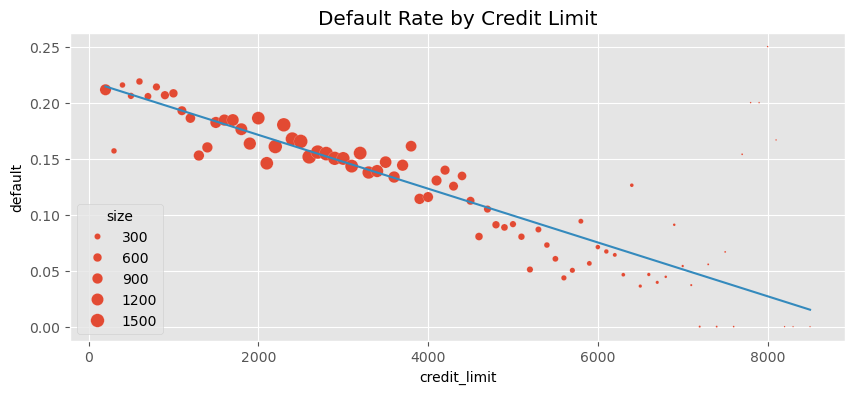

In [10]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")

plt.show()

해당 편향을 보정하려면, 이론적으로 모든 교란 요인에 따라  
- 1.데이터를 나누고  

- 2.나눈 각 그룹 내에서 채무불이행률을 신용 한도에 회귀선을 적합시키고  

- 3.계수를 추출하여 결과의 평균을 구하면 된다.  

하지만 차원의 저주로 인해, 적절한 수의 교란 요인(두 가지 신용점수)을 고려했을 때조차 다음처럼 표본이 하나뿐인 셀이 존재한다. 해당 표본으로는 회귀모델을 만들 수 없으며, 많은 셀이 비어 있다.

In [11]:
risk_data.groupby(['credit_score1','credit_score2']).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

다행히 회귀분석을 통해 이 상황을 해결할 수 있다. 교란 요인을 직접 보정하는 대신, OLS로 추정할 모델에 단순히 교란 요인을 추가하면 된다.
$$
Default_i=\beta_0+\beta_1CreditLim_i+\theta X_i + e_i
$$

여기서 $X$는 교란 요인 벡터이고, $\theta$는 해당 교란 요인과 관련된 매개변수 벡터이다. 매개변수 $\theta$는 특별하지 않고 $\beta_1$과 똑같이 작동한다. 다르게 표현된 이유는 단순히 편향되지 않은 $\beta_1$의 추정값을 얻는 데 도움이 되는 매개변수이기 때문이다. 즉, 이 매개변수의 인과관계 해석에는 크게 신경 쓰지 않아도 되며, 이런 매개변수를 **장애모수(nuisance parameter)** 라고 부른다.

신용 한도 예제에서는 신용점수와 임금을 교란 요인으로 모델에 추가할 수 있다. 그러면 모델을 다음과 같이 만들 수 있다.
$$
Default_i = \beta_0+\beta_1CreditLim_i+\theta_1wage_i+\theta_2creditScore1_i+\theta_3creditScore2_i+e_i
$$

모델에 변수를 포함하는 것이 어떻게 교란 요인을 보정하는지에 대해 더 살펴보겠지만, 현재로서는 이를 쉽게 이해해본다.  
앞의 모델은 $E[y|t,X]$에 대한 것이고, 원하는 모델은 $\frac{\partial }{\partial t}E[y|t,X]$이다. 이 모델을 처치인 신용 한도에 대해 미분하면 $\beta_1$이 나온다. 그리고 $\beta_1$은 신용 한도에 대한 채무불이행률 기댓값의 편도함수라고 볼 수 있다. 직관적으로, **모델의 다른 모든 변수가 고정된 상태에서** 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값이다. 회귀분석이 처치와 결과 사이의 관계를 추정하는 동안 교란 요인을 고정한다는 것을 알 수 있다.

몇 가지 교란 요인을 추가하면 신용 한도와 채무불이행 사이의 관계가 **양수**로 바뀐다.

In [12]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula,data = risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


신용 한도는 1000 단위이고, 채무불이행 여부는 0 또는 1이기 때문에 $\beta_1$의 작은 추정값에 신경 쓸 필요는 없다. 신용 한도를 1달러씩 늘렸을 때 채무불이행률이 증가하는 정도는 아주 작을 것이다. 하지만 이 추정값은 통계적으로 유의하고 신용 한도를 늘릴수록 채무불이행률이 증가하는 것을 알려준다. 교란 요인을 통제함으로써 결과가 우리의 직관과 더 맞게 바뀌었다.

본격적으로 인과추론의 위대한 도구인 **프리슈-워-로벨(Frish-Waugh-Lovell,FWL) 정리**를 다룬다. 이 정리는 편향을 제거하는 방법이지만, 안타깝게도 데이터 과학자에게 많이 알려지지 않았다. *FWL* 정리는 고급 편향 제거 기법을 이해하는 데 꼭 필요하며, **편향을 제거하는 전처리 단계에서 사용**할 수 있기 때문에 매우 유용하다.

은행 예제로 돌아가서, 은행의 많은 데이터 분석가는 신용 한도가 위험뿐 아니라 다양한 사업 지표에 영향을 미치는지(원인이 되는지) 알고 싶다고 하자. 그러나 신용 한도가 어떻게 배정되었는지는 우리만이 아는 상황이다. FWL 정리를 사용함으로써 이러한 지식을 바탕으로 신용 한도 데이터의 편향을 제거하고, 편향이 제거된 데이터를 사용하도록 할 수 있다. 즉, **FWL 정리는 편향 제거 단계와 영향 추정 단계를 분리할 수 있게 해준다.** 이 정리를 배우기 전에 먼저 회귀분석 이론을 간단히 복습한다.

---

## 4.2 회귀분석 이론

여기선 간단하게 회귀분석의 이론을 파악한다. 우선, 회귀분석은 선형 예측 문제를 가장 잘 해결한다. 다음 식에서 $\beta^{*}$를 매개변수 벡터라고 한다.
$$
\beta^{*} = \underset{\beta}{argmax}\ E[(Y_i-X_i'\beta)^2]
$$
선형회귀분석은 평균제곱오차(Mean Squared Error,MSE)를 최소화하는 매개변수를 찾는다. 이를 미분하고 그 결과를 0으로 두면, 이 문제에 대한 선형 해(solution)는 다음과 같다.
$$
\beta^{*} = E[X'X]^{-1}E[X'Y]
$$
표본을 통해 다음과 같이 회귀계수를 추정할 수 있다.
$$
\hat{\beta}=(X'X)^{-1}X'Y
$$

앞서 배운 수식을 통해, 이를 코드로 구현한다. 다음 코드에서는 OLS의 대수적 해를 사용해서 앞 모델의 매개변수를 추정한다(마지막 변수로 절편을 추가했으니 첫 번째 매개변수 추정값은 $\hat{\beta_1}$이 된다).

In [ ]:
X_cols = ['credit_limit','wage','credit_score1','credit_score2']
X = risk_data[X_cols].assign(intercept=1).to_numpy()                ##to_numpy()는 같은 결과 형식 출력을 위한 코드
y = risk_data['default'].to_numpy()


## method 1 : @ 연산자 사용
def regression_1(X,y):
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

## method 2 : .dot() 함수 사용
def regression_2(X,y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

## method 3 : lstsq() 함수 사용
def regression_3(X,y):
    beta, *_ = np.linalg.lstsq(X,y,rcond=None)
    return beta

print(regression_1(X,y))
print(regression_2(X,y))
print(regression_3(X,y))

[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]
[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]
[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]


앞서 `statsmodels`의 `ols` 함수를 사용하여 모델을 추정할 때 얻은 값과 같다. 모두 같은 결과를 출력하는 3가지 방법이 있지만, 1,2번은 직접적으로 역행렬을 계산하기 때문에 만약 $X^TX$가 역행렬이 존재하지 않는 특이행렬에 가까우면($X$의 열들이 종속적인 경우) 불안정한 반면, `lstsq()` 함수를 사용하면 **특이값 분해**를 사용하므로 좀 더 안정적이다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● <code>assign</code> 메서드</strong><br>
    판다스의 <code>.assign()</code> 메서드는 새로 만든 열을 전달하여 새로운 데이터프레임을 반환하는 기능이라고 생각하면 된다.
</div>

### 단순선형회귀

이전 절에서 설명한 $\hat{\beta_1}$ 공식은 일반화된 버전이다. 그러나 단일 설명변수만 있는 경우를 학습하는 것도 도움이 된다. 인과추론에서는 변수 $T$가 결과 $Y$에 미치는 인과효과를 추정하려는 경우가 많다. 단순선형회귀분석을 통해 이 효과를 추정할 수 있다.

단일 설명변수 $T$를 사용할 때 관련된 매개변수는 다음과 같다.
$$
\hat{\tau} = \frac{Cov(Y_i,T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i-\bar{Y})]}{E[(T_i-\bar{T})^2]}
$$
$T$가 무작위로 배정된 경우 $\beta_1$은 $ATE$이다. 중요한 점은 이 간단한 공식을 보고 회귀분석이 어떤 역할을 하는지 확인할 수 있다. 회귀분석은 처치와 결과가 어떻게 함께 움직이는지(분자의 공분산으로 표현)를 파악하고 이를 처치 대상에 따라 조정한다. 이 매개변수는 처치와 결과에 대한 공분산을 처치의 분산으로 나눔으로써 얻을 수 있다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    β를 추정하는 일반적인 공식과 이 식을 연결지을 수 있다. 공분산은 dot product와 밀접한 관련이 있으므로, 공분산/분산 공식에서 X'X가 분모 역할을 하고 X'y가 분자 역할을 한다고 볼 수 있다.
</div>

### 다중선형회귀

설명변수가 두 개 이상일 때는 단순선형회귀를 확장하면 된다. 다른 변수는 보조적인 변수일 뿐이고 진짜 관심 있는 부분은 $T$와 관련된 매개변수 $\tau$를 추정하는 것으로 생각해본다.
$$
y_i = \beta_0 + \tau T_i + \beta_1 X_{1i} + ... + \beta_k X_{ki} + u_i
$$

$\tau$는 다음 공식으로 추정할 수 있다.
$$
\hat{\tau} = \frac{Cov(Y_i,\tilde{T_i})}{Var(\tilde{T_i})}
$$

여기서 $\tilde{T_i}$는 $T_i$를 모든 공변량 $X_{1i}+X_{2i}+...+X_{ki}$에 대해 회귀한 잔차이다.

수식으로 표현하면,  
$$
\hat{T_i} = \theta_0+\theta_1X_{1i}+\theta_2X_{2i}+...+ \theta_{ki}X_{ki}
$$
으로 $\hat{T_i}=E[T_i|X_i]$를 추정한다. $\hat{T_i}$는 통제변수들인 $X_1,X_2...,X_k$가 설명해주는 $T$의 부분이라 생각하면 된다. 여기서 $\tilde{T_i}$는 $T_i-\hat{T_i}$이다.  
**이는 $\boldsymbol{T}$에서 $\boldsymbol{X}$들에 의해 설명되는 부분을 제거한, $\boldsymbol{X}$에 대해 독립적인 부분만 남은 $T$이다.**

다중회귀분석에서 회귀계수의 의미는 **모델의 다른 변수들의 효과를 고려한 후** 얻은 동일 설명변수의 이변량(bivariate) 계수라는 것이다. 인과추론 관점에서 보면 $\tau$는 다른 모든 변수를 활용해 $T$를 예측한 후 얻은 $T$의 이변량 계수이다.

직관적으로 볼 때, 다른 변수를 사용하여 $T$를 예측할 수 있다면 $T$는 무작위가 아니다. 그러나 모든 교란 요인 $X$를 통제하면 $T$를 무작위처럼 보이게 할 수 있다. 그러려면 선형회귀분석을 사용하여 교란 요인에서 $T$를 예측한 다음, $T$에서 해당 회귀에 대한 잔차를 빼주면 $\tilde{T}$가 된다. $T$를 예측하는 데 이미 사용한 변수인 $X$를 이용해서는 $\tilde{T}$를 예측할 수 없다. 아주 깔끔하게 $\tilde{T}$는 $X$의 다른 변수와 연관(상관관계)이 없는 버전의 처치이다.

이 부분이 바로 다음에 학습할 *FWL* 정리이다.

---

## 4.3 프리슈-워-로벨 정리와 직교화

*FWL* 스타일의 직교화(잔차화라고도 함)는 **가장 먼저 사용할 수 있는 편향 제거(debiasing) 기법**이다. 이는 간단하면서도 비실험 데이터를 처치가 무작위로 배정된 것처럼 보이게 한다. *FWL* 정리는 주로 선형회귀에 관한 것이며, *FWL* 스타일의 직교화는 더 넓은 맥락에서 적용되도록 확장되어었다. *FWL* 정리에 따르면 다중선형회귀분석은 한 번에 추정하거나 세 단계로 나누어 추정할 수 있다.

다음과 같이 채무불이행률 `default`를 `credit_limit`,`wage`,`credit_score1`,`credit_score2`에 대해 회귀모형을 만든다.

In [32]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'

model = smf.ols(formula,data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


*FWL* 정리에 따르면 추정 과정을 다음과 같이 세 단계로 나눌 수 있다.  
- 1.**편향 제거 단계** : 처치 $T$를 교란 요인 $X$에 대해 회귀식을 만들어 처치 잔차 $\tilde{T}=T-\hat{T}$를 구한다.  

- 2.**잡음 제거 단계** : 결과 $Y$를 처치 변수 $T$가 제외된 교란 요인 $X$에 대해 회귀식을 만들어 결과 잔차 $\tilde{Y}=Y-\hat{Y}$를 구한다.  

- 3.**결과 모델 단계** : $\tilde{Y}$를 $\tilde{T}$에 대해 회귀식을 만들어 $T$가 $Y$에 미치는 인과효과를 추정한다.

이 3 단계는 그 위의 다중선형회귀분석을 다시 설명한 것 뿐이다. *FWL* 정리는 추정 단계와 회귀 모델이 본질적으로 같음을 보여준다. 그리고 첫 번째 단계처럼 선형회귀의 편향 제거 구성 요소를 분리할 수 있음을 보여준다.

이 세 가지 단계를 좀 더 자세히 살펴본다.

###

### 1. 편향 제거 단계

정확한 인과효과 추정을 위해선 편향 제거 단계가 매우 중요하다. 신용 한도 예시에서, 교란편향의 영향으로 신용 한도에 따라 채무불이행률이 감소하는 추세를 보였다.

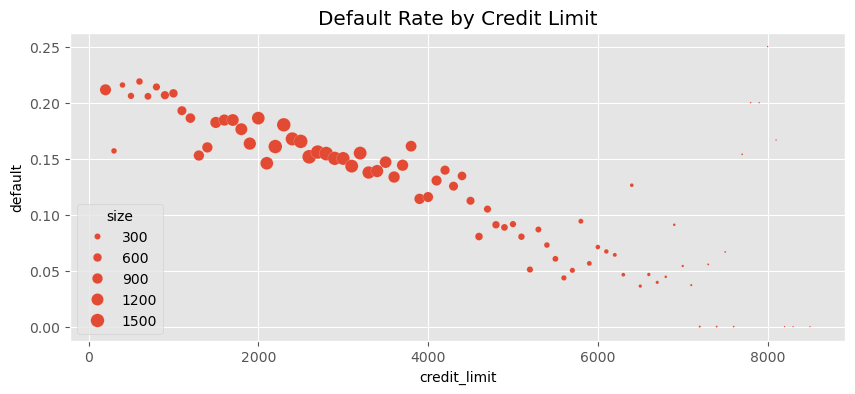

In [36]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")
plt.show()

*FWL* 정리에 따르면, 교란요인으로부터 처치인 신용 한도를 예측하는 회귀모델을 만들어 데이터의 편향을 제거할 수 있다.
$$
\widehat{CreditLim_i} = \theta_0+\theta_1X_{1i}+\theta_2X_{2i}+...+ \theta_{ki}X_{ki}
$$
그 다음 모델으로부터 신용한도에 대한 잔차 $\widetilde{CreditLim}$을 구한다.
$$
\widetilde{CreditLim_i} = CreditLim_i - \widehat{CreditLim_i}+(\ \overline{CreditLim}\ )
$$
이 잔차는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 처치로 볼 수 있다. **예측값을 생성한 변수와 직교하기 때문이다.**

이 단계를 수행하면 0을 중심으로 한 $\widetilde{CreditLim}$이 만들어진다. 편향 제거에 필요없지만, 시각화를 위해 평균 처치인 $\overline{CreditLim}$을 추가해 원래의 $CreditLim$과 같은 범위에 둘 수도 있다.

In [38]:
debiasing_model = smf.ols('credit_limit~wage+credit_score1+credit_score2',
                          data=risk_data).fit()

risk_data_deb = risk_data.assign(
    credit_limit_res=(debiasing_model.resid+risk_data['credit_limit'].mean())
    
)

`default`를 편향이 제거된 처치인 $\widetilde{CreditLim}$으로 회귀분석을 실시하면, 편향 제거 모델에 사용된 교란 요인을 통제하면서 신용 한도가 채무불이행에 미치는 영향을 파악할 수 있다. 여기서 $\beta_1$에 대한 추정값 $\hat{\beta_1}$은 앞서 처치와 교란 요인을 모두 포함한 완전한 모델(Full-model)을 실행하여 얻은 값과 정확히 동일하다.

In [39]:
model_deb_data = smf.ols('default ~ credit_limit_res',data=risk_data_deb).fit()

model_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


하지만 자세히 살펴보면 *p-value*가 이전보다 약간 높다. 이는 분산 감소를 담당하는 잡음 제거 단계를 거치지 않았기 때문이다. 하지만 편향 제거 단계만 적용해도, 모든 교란 요인이 편향 제거 모델에 포함된다면 신용 한도가 채무불이행률에 미치는 인과적 영향에 대하여 편향되지 않은 추정값(*Unbiased estimate*)을 얻을 수 있다.

그래프를 보면, 편향되었을 때와 다르게 두 변수 사이의 관계가 음의 관계를 보이지 않는다.

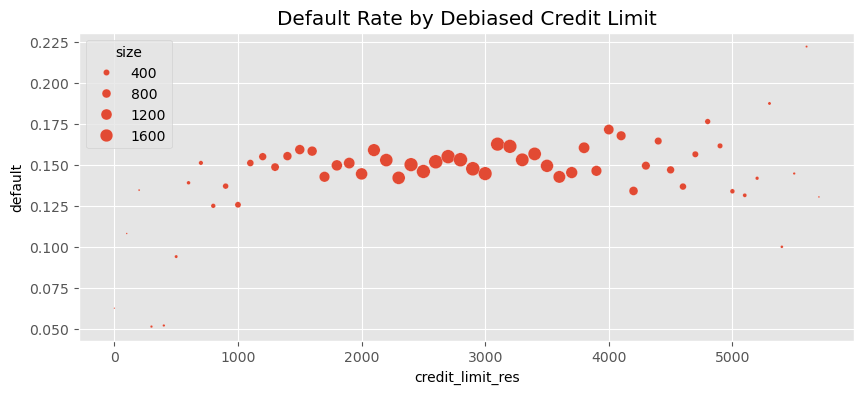

In [42]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")
plt.show()

### 2. 잡음 제거 단계

잡음 제거는 편향 제거만큼 중요하진 않다. 잡음을 제거한다고 처치효과의 추정값이 바뀌지 않지만, 분산을 줄일 수 있다. 이 단계에서는 결과를 처치가 아닌 공변량에 대해 회귀식을 만든다.
$$
\widehat{default_i} = \beta_0+\beta_1X_{1i}+...\beta_kX_{ki}
$$
그 다음 결과에 대한 잔차를 얻는다.
$$
\widetilde{default_i} = default_i - \widehat{default_i}+(\ \overline{default}\ )
$$

In [43]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',data=risk_data_deb
).fit()

risk_data_denoised = risk_data_deb.assign(
    default_res = denoising_model.resid + risk_data_deb['default'].mean()
)

#### 회귀 추정량의 표준오차

다음 단계로 가기 전에, 잡음과 관련해서 회귀 표준 오차의 계산법을 살펴본다. 추정한 회귀계수의 표준오차 공식은 다음과 같다.

$$
SE(\hat{\beta})=\frac{\sigma(\hat\epsilon)}{\sigma(\tilde{T})\sqrt{n-k}}
$$

여기서 $\hat{\epsilon}$은 회귀모델의 잔차이고, $n$은 샘플의 수, $k$는 절편을 포함한 파라미터의 개수이다.

표준오차를 코드로 확인해본다.

In [47]:
model_se = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',
    data = risk_data
).fit()

print('SE regression:',model_se.bse['wage'])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data = risk_data
).fit()

#모델의 자유도 : N-4
se_formula = (np.std(model_se.resid)
              / (np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4))
              )

print('SE formula:',se_formula)

SE regression: 5.364242347548206e-06
SE formula: 5.364242347548192e-06


해당 식은 잡음 제거 단계를 직관적으로 이해하는 데 도움을 준다. 분자를 살펴보면, 결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아진다. 또한 처치가 결과를 많이 설명하면 파라미터 추정값의 표준오차도 작아지는 것을 알 수 있다.

**오차는 직교화된 처치의 분산에 반비례한다.** 처치가 많이 바뀌면 그 영향을 측정하기가 더 쉬워진다.

#### 연속형 처치를 이용한 실험

표준오차 공식은 회귀분석에서 파라미터 추정값으로 효과를 측정하고자 하는 실험을 설계할때도 유용하다. 특히, 연속형 처치를 랜덤화하려는 경우에는 이 방법이 더 좋다. 이 경우에 표준오차 공식은 다음과 같이 근사할 수 있다.
$$
SE \approx \frac{\sigma(y)}{\sigma(T)\sqrt{n-k}}
$$

### 3. 최종 결과 모델

*FWL* 정리의 마지막 단계인 결과 모델에서는 두 잔차 $\tilde{Y}$와 $\tilde{T}$를 이용해서 회귀식을 만들면 된다.
$$
\hat{\tilde{Y_i}} =\gamma_0 + \gamma_1 \tilde{T_i}
$$

In [50]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data = risk_data_denoised).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


편향 제거 단계에서 얻은 파라미터 추정값은 신용한도와 다른 모든 공변량을 사용하여 회귀했을 때와 완전히 동일하다. 또한 표준오차의 *p-value*도 이제 모든 변수를 포함하여 처음 모델을 실행했을 때와 같다. 이것이 잡음 제거 단계의 효과이다. 다음은 편향이 제거된 처치, 잡음이 제거된 결과 간의 관계를 최종 모델의 예측값과 함께 표현한 그래프이다.

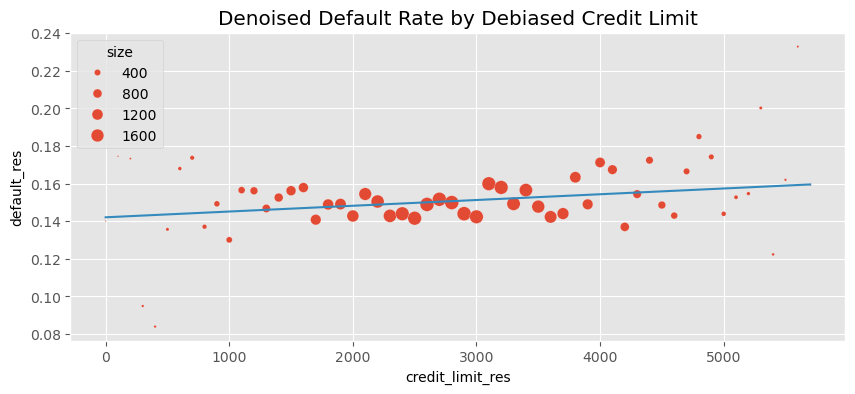

In [55]:
plt_df = (risk_data_denoised
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")
plt.show()

### *FWL* 정리 요약

*FWL* 정리를 시각적으로 이해해본다. 처치 $T$와 결과 $Y$ 사이의 관계를 추정하고 싶지만 교란요인 $X$가 있을 때, 처치는 $X$축, 결과는 $y$축에 표시하고 교란요인은 색을 사용해 표시한다.

처음에는 처치와 결과는 음의 기울기였지만, 도메인 지식에서 비롯된 확실한 근거로 볼 때, 양의 관계라고 확신하는 경우, 편향을 제거하고 인과효과를 추정한다.

이를 위해 먼저 선형회귀를 사용하여 $E[Y|T]$를 추정한다. 그 다음 편향이 제거된 버전의 처치 $T-E[T|X]$를 구한다. 편향이 제거된 처치를 사용하면 찾으려는 양의 관계를 확인할 수 있지만 여전히 잡음이 많다.

<center>

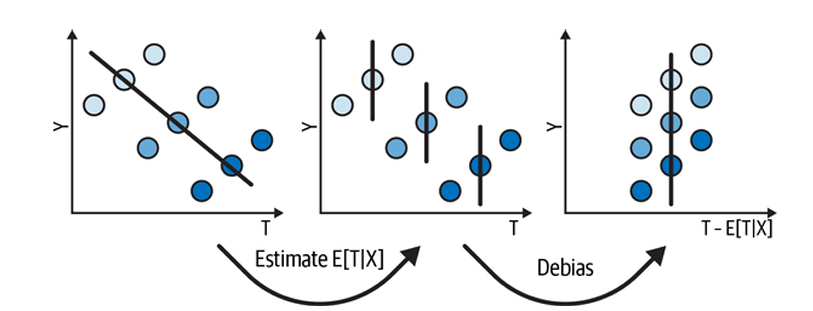

</center>

따라서 잡음을 제거하기 다시 회귀모델을 사용하여 $E[Y|X]$를 추정하고 잡음이 제거된 결과인 $Y-E[Y|X]$를 만든다. 잡음이 제거된 결과를 $X$에 의해 설명된 모든 분산을 고려한 후의 결과라고 볼 수 있다. $X$가 $Y$의 분산을 많이 설명하면 잡음이 줄어들어, 실제로 관심있는 $T$와 $Y$ 사이의 관계를 더 쉽게 파악할 수 있다.

<center>

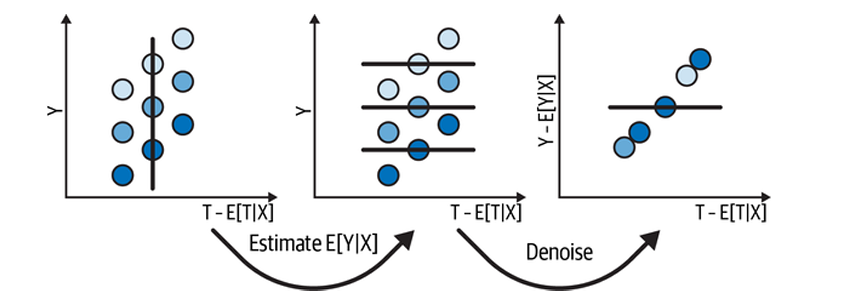

</center>

마지막으로 편향, 잡음을 제거하여 $T$와 $Y$ 사이의 관계를 명확하게 볼 수 있다. 이제 이 데이터에 최종 모델을 적합시키면 된다. 마지막 회귀식은 $Y$를 $T$와 $X$에 동시에 회귀했을 때의 기울기와 정확히 같다.

---

## 4.4 결과 모델로서의 회귀분석